# **Introduction**

For my final project for Scripting Languages, I aim to explore the relationship between global economic development and fertility rates and life expectancy. This research aims to understand how a country’s Gross Domestic Product (GDP) per capita and GDP growth rate influence these demographic factors, focusing on differences across various income groups: low, middle, and high-income countries.

My research question is as follows: "**How do economic factors influence fertility rates and life expectancy across different income levels?**"

# Notebook Structure

**1.   Preparing the Dataset**:

How the population and GDP datasets were collected, cleaned, and merged to ensure consistency and accuracy in analysis.

**2.   Descriptive Statistics:**

A statistical overview of the key variables (GDP per capita, GDP real rates of growth, fertility rates, and life expectancy) provide a preliminary understanding of the data. This section also includes the creation of income groups.

**3. Multivariate Regression Analysis:**

Two regression models assess how GDP per capita and GDP growth influence fertility and life expectancy, offering insights into the strength and direction of these relationships.

**4. Comparative Analysis:**


*   Box plots are used to visualize the distribution of fertility rates and life expectancy across different income levels.
*   Line plots illustrate trends over time, showing how fertility and life expectancy evolve across income categories.
* ANOVA tests evaluate whether there are significant differences in fertility rates and life expectancy between different income groups.

**Additional notes**:
* In many of the code blocks that follow, ChatGPT v2 (consulted between 1/12/2024 and 7/12/2024) was used to provide a basis for or improve the code.
* This notebook was created in Google Colab and must be run in a similar way for the best user experience.


# **Preparing the Dataset: Importing, Cleaning, and Merging**

The datasets on which this Notebook is based were collected from [UNdata](https://data.un.org/), which is a web-based data service that provides free access to global statistical databases. The first dataset contains information related to population growth, fertility, life expectancy, and mortality in 268 countries, regions, or areas. The second dataset focuses on GDP and GDP per capita in 244 countries, regions, or areas.

Before importing both CSV files in this Notebook, I did some preliminary data cleaning in Excel: I removed the first row since the column headers were situated in the second row, and then I deleted the first column in both files ('T03' for the population dataset and 'T13' for the GDP dataset), which contained numeric identifiers for all the countries, regions or areas. Finally, I gave a name to the now first column (which was unnamed in the original files), namely 'Region/Country/Area' since it contains the names of the countries, regions, or areas in string format. Both files were then saved as CSV files (and can be found on [my GitHub](https://github.com/EmmaLefever/Scripting-Languages-Final-Project)).


# Importing

First I upload both CSV files and import the relevant libraries I will need for my analysis.

In [1]:
from google.colab import files

uploaded = files.upload() #the output of this cell will give me the option to choose files from my computer, which is where I saved the datasets

Saving GDP and GDP Per Capita.csv to GDP and GDP Per Capita.csv
Saving Population Growth, Fertility and Mortality Indicators.csv to Population Growth, Fertility and Mortality Indicators.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway

# Cleaning the Population Dataset

Next, I read the Population Growth, Fertility and Mortality Indicators.csv (which is delimiter seperated by a semicolon) in a pandas dataframe.

In [3]:
try:
    df_population = pd.read_csv(io.BytesIO(uploaded['Population Growth, Fertility and Mortality Indicators.csv']), delimiter=';')

except KeyError:
    print("Error: 'Population Growth, Fertility and Mortality Indicators.csv' not found among uploaded files.")
    print("Please upload the correct file and try again.")

except pd.errors.ParserError:
    print("Error: Could not parse the CSV file.")
    print("Please check the file format and delimiter.")

except Exception as e:
    print(f"An unexpected error occurred: {e}") #when another error than the above occurs, I will print it out

To verify that my file was correctly read, I print out the first few rows.

In [4]:
df_population.head()

,Region/Country/Area,Year,Series,Value,Footnotes,Source
0,"Total, all countries or areas",2010,Population annual rate of increase (percent),1.3,NaN,"United Nations Population Division, New York, ..."
1,"Total, all countries or areas",2010,Total fertility rate (children per women),2.6,NaN,"United Nations Population Division, New York, ..."
2,"Total, all countries or areas",2010,"Infant mortality for both sexes (per 1,000 liv...",37.1,NaN,"United Nations Statistics Division, New York, ..."
3,"Total, all countries or areas",2010,"Maternal mortality ratio (deaths per 100,000 p...",254,NaN,"World Health Organization (WHO), the United Na..."
4,"Total, all countries or areas",2010,Life expectancy at birth for both sexes (years),70.1,NaN,"United Nations Population Division, New York, ..."


Since I will not need the 'Footnotes' and 'Source' columns for my analysis, I will drop them.

In [5]:
df_population = df_population.drop(columns=["Footnotes", "Source"])

To verify that these columns were dropped, I check my rows again.

In [6]:
df_population.head()

,Region/Country/Area,Year,Series,Value
0,"Total, all countries or areas",2010,Population annual rate of increase (percent),1.3
1,"Total, all countries or areas",2010,Total fertility rate (children per women),2.6
2,"Total, all countries or areas",2010,"Infant mortality for both sexes (per 1,000 liv...",37.1
3,"Total, all countries or areas",2010,"Maternal mortality ratio (deaths per 100,000 p...",254
4,"Total, all countries or areas",2010,Life expectancy at birth for both sexes (years),70.1


Next, I check whether the 'Value' column contains numeric data types or if they are encoded in another data type.

In [7]:
try:
  pd.to_numeric(df_population['Value'])
  print("The 'Value' column contains numeric data.")
except ValueError as e:
  print("The 'Value' column does not contain only numeric data.")
  print(e) #when an error occurs, I will print it out to get insight into the format of the data

The 'Value' column does not contain only numeric data.
Unable to parse string "1,052" at position 1797


Since there are non-numeric data types present, I want to count the number of non-numeric occurrences in the column 'Value'.

In [8]:
if 'Value' in df_population.columns:
    non_numeric_count = df_population['Value'][pd.to_numeric(df_population['Value'], errors='coerce').isna()].count()
    print(f"Number of non-numeric occurrences in 'Value' column: {non_numeric_count}")

Number of non-numeric occurrences in 'Value' column: 11


There are 11 non-numeric occurrences in the column 'Value'. I need to ensure all values in this column are floats. When the following code encounters a string value, it will parse it into a float.

In [9]:
#to handle the use of comma's to distinguish thousands, I got inspiration from the following source: https://stackoverflow.com/questions/8421922/how-do-i-convert-a-currency-string-to-a-floating-point-number-in-python
from re import sub
from decimal import Decimal

if 'Value' in df_population.columns:
    for i, value in df_population['Value'].items():
        try:
            if isinstance(value, str):
              print(f"Not a float: {value}")
              df_population.at[i, 'Value'] = Decimal(sub(r'[^\d.-]', '', value)) #this regular expression keeps the value of the number (positive or negative)
        except ValueError:
          print("Some error occured")

Streaming output truncated to the last 5000 lines.
Not a float: 1.0
Not a float: 1.6
Not a float: 4.5
Not a float: 12
Not a float: 81.9
Not a float: 79.9
Not a float: 83.9
Not a float: 0.7
Not a float: 1.5
Not a float: 4.3
Not a float: 11
Not a float: 82.0
Not a float: 80.0
Not a float: 84.1
Not a float: 0.9
Not a float: 1.5
Not a float: 3.9
Not a float: 82.8
Not a float: 80.9
Not a float: 84.8
Not a float: 2.7
Not a float: 1.8
Not a float: 7.2
Not a float: 75.8
Not a float: 73.0
Not a float: 78.8
Not a float: 2.2
Not a float: 1.2
Not a float: 8.7
Not a float: 74.8
Not a float: 72.5
Not a float: 77.3
Not a float: 0.9
Not a float: 1.2
Not a float: 7.3
Not a float: 75.6
Not a float: 73.2
Not a float: 78.1
Not a float: 2.0
Not a float: 5.9
Not a float: 97.3
Not a float: 1,052
Not a float: 49.3
Not a float: 48.1
Not a float: 50.5
Not a float: 1.6
Not a float: 6.0
Not a float: 84.7
Not a float: 909
Not a float: 52.8
Not a float: 51.2
Not a float: 54.5
Not a float: 2.7
Not a float: 6.0
Not a

To verify, I check again whether there are non-numeric occurrences in the 'Value' column.

In [10]:
if 'Value' in df_population.columns:
    non_numeric_count = df_population['Value'][pd.to_numeric(df_population['Value'], errors='coerce').isna()].count()
    print(f"Number of non-numeric occurrences in 'Value' column: {non_numeric_count}")

Number of non-numeric occurrences in 'Value' column: 0


Now that all values in the 'Value' column are the correct data type, I still need to ensure that the dtype of the column is converted to float, which makes it suitable for math operations.

In [11]:
df_population['Value'] = pd.to_numeric(df_population['Value'])

df_population['Value'] = df_population['Value'].astype(float)

Finally, I verify if this conversion was successful.

In [12]:
print(df_population.dtypes)

Region/Country/Area     object
Year                     int64
Series                  object
Value                  float64
dtype: object


The next step is to create a pivot table based on df_population where each unique value in the 'Series' column (which contains the type of data that was collected, such as 'life expectancy at birth for both sexes (years)') becomes a new column. This will also distribute the values from the 'Value' column to their new corresponding columns.

In [13]:
population_pivot = df_population.pivot_table(index=["Region/Country/Area", "Year"], columns="Series", values="Value", aggfunc="first").reset_index()

population_pivot.columns.name = None #here I remove the hierarchical column name "Series"

population_pivot.head()

,Region/Country/Area,Year,"Infant mortality for both sexes (per 1,000 live births)",Life expectancy at birth for both sexes (years),Life expectancy at birth for females (years),Life expectancy at birth for males (years),"Maternal mortality ratio (deaths per 100,000 population)",Population annual rate of increase (percent),Total fertility rate (children per women)
0,Afghanistan,2010,64.8,60.9,62.4,59.3,899.0,2.7,6.1
1,Afghanistan,2015,54.5,62.7,64.6,60.8,776.0,2.3,5.4
2,Afghanistan,2020,45.8,62.6,65.4,59.9,620.0,3.3,4.8
3,Afghanistan,2022,40.8,62.9,66.2,59.8,NaN,2.7,4.5
4,Africa,2010,60.9,58.6,60.2,57.0,593.0,2.6,4.9


Now I need to check if there are missing values in the pivot table.

In [14]:
print(population_pivot.isnull().sum())

Region/Country/Area                                           0
Year                                                          0
Infant mortality for both sexes (per 1,000 live births)       6
Life expectancy at birth for both sexes (years)               6
Life expectancy at birth for females (years)                  6
Life expectancy at birth for males (years)                    6
Maternal mortality ratio (deaths per 100,000 population)    365
Population annual rate of increase (percent)                  3
Total fertility rate (children per women)                     6
dtype: int64


Since there are missing values, I want explore them (and behind the screen: Compare them to the original dataset) by looking at the missing values for a random column, here 'Maternal mortality ratio (deaths per 100,000 population)'.

In [15]:
missing_values_maternal_mortality = population_pivot['Maternal mortality ratio (deaths per 100,000 population)'].isnull()
population_pivot[missing_values_maternal_mortality]

,Region/Country/Area,Year,"Infant mortality for both sexes (per 1,000 live births)",Life expectancy at birth for both sexes (years),Life expectancy at birth for females (years),Life expectancy at birth for males (years),"Maternal mortality ratio (deaths per 100,000 population)",Population annual rate of increase (percent),Total fertility rate (children per women)
3,Afghanistan,2022,40.8,62.9,66.2,59.8,NaN,2.7,4.5
7,Africa,2022,44.2,62.2,64.1,60.2,NaN,2.3,4.2
11,Albania,2022,8.2,76.8,79.5,74.5,NaN,-0.4,1.4
15,Algeria,2022,16.6,77.1,78.5,75.9,NaN,1.6,2.8
16,American Samoa,2010,8.0,72.1,74.3,70.0,NaN,-0.9,3.3
...,...,...,...,...,...,...,...,...,...
1008,Western Sahara,2015,30.8,69.3,71.3,67.7,NaN,2.8,2.5
1009,Western Sahara,2022,23.7,71.0,73.1,69.3,NaN,2.0,2.3
1013,Yemen,2022,46.8,63.7,67.2,60.5,NaN,2.2,3.7
1017,Zambia,2022,38.2,61.8,64.5,59.1,NaN,2.7,4.2


Once I verified that these are actual missing values (i.e., in the original dataset there is indeed no value for this column), I fill in the missing values with 0 instead of NaN.

In [16]:
population_pivot = population_pivot.fillna(0)

To confirm, I check that there are no more missing values.

In [17]:
print(population_pivot.isnull().sum())

Region/Country/Area                                         0
Year                                                        0
Infant mortality for both sexes (per 1,000 live births)     0
Life expectancy at birth for both sexes (years)             0
Life expectancy at birth for females (years)                0
Life expectancy at birth for males (years)                  0
Maternal mortality ratio (deaths per 100,000 population)    0
Population annual rate of increase (percent)                0
Total fertility rate (children per women)                   0
dtype: int64


# Cleaning the GDP Dataset

Now that the population dataset is clean, I will repeat a similar process for the GDP dataset. First, I read the GDP and GDP Per Capita.csv (which is delimiter seperated by a semicolon) in a pandas dataframe.

In [18]:
try:
    df_gdp = pd.read_csv(io.BytesIO(uploaded['GDP and GDP Per Capita.csv']), delimiter=';')

except KeyError:
    print("Error: 'GDP and GDP Per Capita.csv' not found among uploaded files.")
    print("Please upload the correct file and try again.")

except pd.errors.ParserError:
    print("Error: Could not parse the CSV file.")
    print("Please check the file format and delimiter.")

except Exception as e:
    print(f"An unexpected error occurred: {e}") #when another error than the above occurs, I will print it out

To verify that my file was correctly read, I print out the first few rows.

In [19]:
df_gdp.head()

,Region/Country/Area,Year,Series,Value,Footnotes,Source
0,"Total, all countries or areas",1995,GDP in current prices (millions of US dollars),"31,269,041",NaN,"United Nations Statistics Division, New York, ..."
1,"Total, all countries or areas",2005,GDP in current prices (millions of US dollars),"47,775,404",NaN,"United Nations Statistics Division, New York, ..."
2,"Total, all countries or areas",2010,GDP in current prices (millions of US dollars),"66,578,017",NaN,"United Nations Statistics Division, New York, ..."
3,"Total, all countries or areas",2015,GDP in current prices (millions of US dollars),"75,283,835",NaN,"United Nations Statistics Division, New York, ..."
4,"Total, all countries or areas",2019,GDP in current prices (millions of US dollars),"87,728,744",NaN,"United Nations Statistics Division, New York, ..."


Since I will not need the 'Footnotes' and 'Source' columns for my analysis, I will drop them.

In [20]:
df_gdp = df_gdp.drop(columns=["Footnotes", "Source"])

To verify that these columns were dropped, I check my rows again.

In [21]:
df_gdp.head()

,Region/Country/Area,Year,Series,Value
0,"Total, all countries or areas",1995,GDP in current prices (millions of US dollars),"31,269,041"
1,"Total, all countries or areas",2005,GDP in current prices (millions of US dollars),"47,775,404"
2,"Total, all countries or areas",2010,GDP in current prices (millions of US dollars),"66,578,017"
3,"Total, all countries or areas",2015,GDP in current prices (millions of US dollars),"75,283,835"
4,"Total, all countries or areas",2019,GDP in current prices (millions of US dollars),"87,728,744"


Next, I check whether the 'Value' column contains numeric data types or if they are encoded in another data type.

In [22]:
try:
  pd.to_numeric(df_gdp['Value'])
  print("The 'Value' column contains numeric data.")
except ValueError as e:
  print("The 'Value' column does not contain only numeric data.")
  print(e) #when an error occurs, I will print it out to get insight into the format of the data

The 'Value' column does not contain only numeric data.
Unable to parse string "31,269,041" at position 0


Since there are non-numeric data types present, I want to count the number of non-numeric occurrences in the column 'Value'.

In [23]:
if 'Value' in df_gdp.columns:
    non_numeric_count = df_gdp['Value'][pd.to_numeric(df_gdp['Value'], errors='coerce').isna()].count()
    print(f"Number of non-numeric occurrences in 'Value' column: {non_numeric_count}")

Number of non-numeric occurrences in 'Value' column: 4486


There are 4486 non-numeric occurrences in the column 'Value'. I need to ensure all values in this column are floats. When the following code encounters a string value, it will parse it into a float.

In [24]:
#to handle the use of comma's to distinguish thousands, I got inspiration from the following source: https://stackoverflow.com/questions/8421922/how-do-i-convert-a-currency-string-to-a-floating-point-number-in-python
from re import sub
from decimal import Decimal

if 'Value' in df_gdp.columns:
    for i, value in df_gdp['Value'].items():
        try:
            if isinstance(value, str):
              print(f"Not a float: {value}")
              df_gdp.at[i, 'Value'] = Decimal(sub(r'[^\d.-]', '', value))
        except ValueError:
          print("Some error occured")

Streaming output truncated to the last 5000 lines.
Not a float: 1,672
Not a float: 1,542
Not a float: 1,608
Not a float: 4,185
Not a float: 9,237
Not a float: 12,760
Not a float: 18,050
Not a float: 23,744
Not a float: 22,999
Not a float: 23,690
Not a float: 5.9
Not a float: 13.2
Not a float: 6.0
Not a float: 7.0
Not a float: 7.1
Not a float: -3.1
Not a float: 3.0
Not a float: 10,865
Not a float: 19,502
Not a float: 27,481
Not a float: 32,186
Not a float: 39,671
Not a float: 40,804
Not a float: 45,368
Not a float: 822
Not a float: 1,129
Not a float: 1,382
Not a float: 1,399
Not a float: 1,539
Not a float: 1,540
Not a float: 1,668
Not a float: 13,858
Not a float: 21,579
Not a float: 25,370
Not a float: 32,186
Not a float: 37,474
Not a float: 37,658
Not a float: 39,032
Not a float: 2.9
Not a float: 2.2
Not a float: 2.9
Not a float: 5.7
Not a float: 3.5
Not a float: 0.5
Not a float: 3.6
Not a float: 605,943
Not a float: 1,173,158
Not a float: 1,617,267
Not a float: 1,556,129
Not a float: 

To verify, I check again whether there are non-numeric occurrences in the 'Value' column.

In [25]:
if 'Value' in df_gdp.columns:
    non_numeric_count = df_gdp['Value'][pd.to_numeric(df_gdp['Value'], errors='coerce').isna()].count()
    print(f"Number of non-numeric occurrences in 'Value' column: {non_numeric_count}")

Number of non-numeric occurrences in 'Value' column: 0


Now that all values in the 'Value' column are the correct data type, I still need to ensure that the dtype of the column is converted to float, which makes it suitable for math operations.

In [26]:
df_gdp['Value'] = pd.to_numeric(df_gdp['Value'])

df_gdp['Value'] = df_gdp['Value'].astype(float)

Finally, I verify if this conversion was successful.

In [27]:
print(df_gdp.dtypes)

Region/Country/Area     object
Year                     int64
Series                  object
Value                  float64
dtype: object


The next step is to create a pivot table based on df_gdp where each unique value in the 'Series' column (which contains the type of data that was collected, such as 'GDP per capita (US dollars)') becomes a new column. This will also distribute the values from the 'Value' column to their new corresponding columns.

In [28]:
gdp_pivot = df_gdp.pivot_table(index=["Region/Country/Area", "Year"], columns="Series", values="Value", aggfunc="first").reset_index()

gdp_pivot.columns.name = None #here I remove the hierarchical column name "Series"

gdp_pivot.head()


,Region/Country/Area,Year,GDP in constant 2015 prices (millions of US dollars),GDP in current prices (millions of US dollars),GDP per capita (US dollars),GDP real rates of growth (percent)
0,Afghanistan,1995,6335.0,2757.0,168.0,30.5
1,Afghanistan,2005,9596.0,6221.0,255.0,7.5
2,Afghanistan,2010,14744.0,14699.0,521.0,5.2
3,Afghanistan,2015,18713.0,18713.0,554.0,-1.4
4,Afghanistan,2019,20510.0,18904.0,501.0,3.9


Now I need to check if there are missing values in the pivot table.

In [29]:
print(gdp_pivot.isnull().sum())

Region/Country/Area                                     0
Year                                                    0
GDP in constant 2015 prices (millions of US dollars)    1
GDP in current prices (millions of US dollars)          0
GDP per capita (US dollars)                             1
GDP real rates of growth (percent)                      3
dtype: int64


Since there are missing values, I want explore them (and behind the screen: Compare them to the original dataset) by looking at the missing values for a random column, here 'GDP real rates of growth (percent)'.

In [30]:
missing_values_GDP_growth = gdp_pivot['GDP real rates of growth (percent)'].isnull()
gdp_pivot[missing_values_GDP_growth]

,Region/Country/Area,Year,GDP in constant 2015 prices (millions of US dollars),GDP in current prices (millions of US dollars),GDP per capita (US dollars),GDP real rates of growth (percent)
399,Cura�ao,1995,NaN,0.0,NaN,NaN
400,Cura�ao,2005,2907.0,2345.0,15921.0,NaN
1340,Sint Maarten (Dutch part),2005,923.0,708.0,22479.0,NaN


Once I verified that these are actual missing values (i.e., in the original dataset there is indeed no value for this column), I fill in the missing values with 0 instead of NaN.

In [31]:
gdp_pivot = gdp_pivot.fillna(0)

To confirm, I check that there are no more missing values.

In [32]:
print(gdp_pivot.isnull().sum())

Region/Country/Area                                     0
Year                                                    0
GDP in constant 2015 prices (millions of US dollars)    0
GDP in current prices (millions of US dollars)          0
GDP per capita (US dollars)                             0
GDP real rates of growth (percent)                      0
dtype: int64


# Merging the DataFrames

Since both datasets are now clean, I will merge them into one dataframe to facilitate statistical analysis. To achieve this, both pivot tables will be merged on their common columns 'Region/Country/Area' and 'Year'.

In [33]:
merged_df = population_pivot.merge(
    gdp_pivot[['Region/Country/Area', 'Year', 'GDP in constant 2015 prices (millions of US dollars)', 'GDP in current prices (millions of US dollars)', 'GDP per capita (US dollars)', 'GDP real rates of growth (percent)']],
    on=['Region/Country/Area', 'Year'],
    how='inner'
)

merged_df.columns

Index(['Region/Country/Area', 'Year',
       'Infant mortality for both sexes (per 1,000 live births)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for females (years)',
       'Life expectancy at birth for males (years)',
       'Maternal mortality ratio (deaths per 100,000 population)',
       'Population annual rate of increase (percent)',
       'Total fertility rate (children per women)',
       'GDP in constant 2015 prices (millions of US dollars)',
       'GDP in current prices (millions of US dollars)',
       'GDP per capita (US dollars)', 'GDP real rates of growth (percent)'],
      dtype='object')

The columns of this new dataframe are a combination of the columns in the population and GDP datasets.

# **Descriptive Statistics**

Now I can generate some descriptive statistics of relevant columns for our analysis.

In [34]:
descriptive_stats = merged_df[[
    'Total fertility rate (children per women)',
    'Life expectancy at birth for both sexes (years)',
    'Life expectancy at birth for males (years)',
    'Life expectancy at birth for females (years)',
    'GDP per capita (US dollars)',
    'GDP real rates of growth (percent)'
]].describe()

descriptive_stats

,Total fertility rate (children per women),Life expectancy at birth for both sexes (years),Life expectancy at birth for males (years),Life expectancy at birth for females (years),GDP per capita (US dollars),GDP real rates of growth (percent)
count,695.000000,695.000000,695.000000,695.000000,695.000000,695.000000
mean,2.740432,71.052518,68.485036,73.695396,14993.894964,1.156835
std,1.388235,9.298757,9.014473,9.675517,22130.290705,6.854976
min,0.000000,0.000000,0.000000,0.000000,223.000000,-36.100000
25%,1.700000,65.600000,63.100000,68.200000,1925.500000,-2.200000
50%,2.300000,72.800000,69.500000,76.100000,5929.000000,2.100000
75%,3.500000,77.400000,74.500000,80.200000,18242.500000,4.850000
max,7.500000,85.300000,82.900000,88.200000,170270.000000,43.500000


This output already reveals several insights about global demographic and economic indicators. The total fertility rate averages 2.74 children per woman, with a wide range (0 to 7.5), suggesting significant variation in birth rates across regions. Life expectancy at birth averages 71 years, with women typically living longer (mean 73.7 years) than men (mean 68.5 years). GDP per capita shows vast economic disparities, with an average of \$14,993 but a standard deviation of \$22,130, indicating a skewed distribution with extreme wealth in some areas (maximum $170,270). The real GDP growth rates also vary widely, from -36.1% to a growth of 43.5%.

Given the high standard deviation of GDP per capita, we can generate a histogram plot to explore the distribution of this economic indicator.

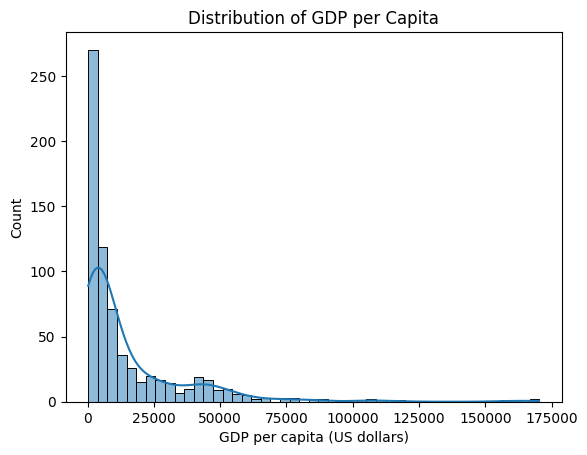

In [35]:
#Here I visualize the distribution of GDP per capita
sns.histplot(merged_df['GDP per capita (US dollars)'], kde=True)
plt.title("Distribution of GDP per Capita")
plt.show()

We can see that the data is highly skewed to the right, with most countries concentrated in the lower GDP per capita range. A significant number of countries have GDP per capita values below \$25,000, while very few exceed $100,000.

To get a preliminary insights on the relation between economic factors and fertility rates and life expectancy, I can calculate the correlations between GDP per capita, total fertility rate, and life expectancy at birth.

In [36]:
correlations = merged_df[[
    'GDP per capita (US dollars)',
    'Total fertility rate (children per women)',
    'Life expectancy at birth for both sexes (years)'
]].corr()

correlations

,GDP per capita (US dollars),Total fertility rate (children per women),Life expectancy at birth for both sexes (years)
GDP per capita (US dollars),1.000000,-0.439708,0.506508
Total fertility rate (children per women),-0.439708,1.000000,-0.647494
Life expectancy at birth for both sexes (years),0.506508,-0.647494,1.000000


GDP per capita is negatively correlated with the total fertility rate (-0.44), indicating that as income levels rise, fertility rates tend to decline. Conversely, GDP per capita has a moderate positive correlation (0.51) with life expectancy, suggesting that wealthier nations often have better healthcare systems and living conditions, leading to longer lives. Finally, there is a strong negative correlation (-0.65) between fertility rates and life expectancy, reflecting that countries with lower birth rates typically experience higher life expectancies.

To analyze how economic factors influence fertility rates and life expectancy across different income levels, it is essential to categorize countries into income groups. For this, I will adopt the [World Bank's classification](https://ourworldindata.org/grapher/world-bank-income-groups#:~:text=Low%2Dincome%20countries%20are%20those,%244%2C516%20and%20%2414%2C005%20in%202023.), which defines income groups based on Gross National Income (GNI) per capita thresholds.

GNI provides a broader perspective compared to GDP as it includes income earned by residents from foreign investments and subtracts income earned within a country by foreign residents or businesses. However, using GNI to create income groups based on GDP data in this analysis is justified because both measures are highly correlated.

The World Bank's thresholds categorize countries into four groups:

1.   **Low-income countries**: GNI per capita of \$1,145 or less.
2.   **Lower-middle-income countries**: GNI per capita between \$1,146 and \$4,515.
3. **Upper-middle-income countries**: GNI per capita between \$4,516 and \$14,005.
4. **High-income countries**: GNI per capita of more than \$14,005.


In [37]:
def categorize_gni(gni):
    if gni <= 1145:
        return 'Low-income'
    elif gni <= 4515:
        return 'Lower-middle-income'
    elif gni <= 14005:
        return 'Upper-middle-income'
    else:
        return 'High-income'

merged_df['GDP Category'] = merged_df['GDP per capita (US dollars)'].apply(categorize_gni) #here I apply the categorization to the 'GDP per capita (US dollars)' column

merged_df[['Region/Country/Area', 'Year', 'GDP per capita (US dollars)', 'GDP Category']].head(20)

,Region/Country/Area,Year,GDP per capita (US dollars),GDP Category
0,Afghanistan,2010,521.0,Low-income
1,Afghanistan,2015,554.0,Low-income
2,Afghanistan,2020,517.0,Low-income
3,Africa,2010,1929.0,Lower-middle-income
4,Africa,2015,2007.0,Lower-middle-income
5,Africa,2020,1799.0,Lower-middle-income
6,Albania,2010,4094.0,Lower-middle-income
7,Albania,2015,3950.0,Lower-middle-income
8,Albania,2020,5278.0,Upper-middle-income
9,Algeria,2010,4496.0,Lower-middle-income


# **Multivariate Regression Analysis**

Before performing a comparative analysis based on the income groups, we can further examine how GDP per capita and GDP growth rate impact (1) fertility and (2) life expectancy with a multivariate regression analysis. Based on the previous correlations, we can expect to find a negative linear relationship between both economic indicators and total fertility rate. The first multivariate regression analysis thus researches the relationship between total fertility rate (dependent variable) and two independent variables: GDP per capita and GDP real growth rates.


In [38]:
X = merged_df[['GDP per capita (US dollars)', 'GDP real rates of growth (percent)']] #here I define the independent variables

y = merged_df['Total fertility rate (children per women)'] #here I define the dependent variable

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                                        OLS Regression Results                                       
Dep. Variable:     Total fertility rate (children per women)   R-squared:                       0.239
Model:                                                   OLS   Adj. R-squared:                  0.236
Method:                                        Least Squares   F-statistic:                     108.5
Date:                                       Sat, 14 Dec 2024   Prob (F-statistic):           1.05e-41
Time:                                               11:36:40   Log-Likelihood:                -1118.9
No. Observations:                                        695   AIC:                             2244.
Df Residuals:                                            692   BIC:                             2257.
Df Model:                                                  2                                         
Covariance Type:                                   nonrobust                      

The model explains approximately 23.9% of the variation in fertility rates, as shown by the R-squared value.

We can see that the base fertility rate, as indicated by the constant, is estimated at 3.097 children per woman when both independent variables are zero. This value is statistically significant (p < 0.001).

The coefficient of -2.711e-05 indicates a small but significant negative relationship of GDP per capita with fertility. For every $1 increase in GDP per capita, the fertility rate decreases slightly.

On the other hand, the coefficient of 0.0432 suggests a positive and significant relationship between GDP real rates of growth and fertility. Higher GDP growth rates are associated with slightly higher fertility rates.

However, the Durbin-Watson statistic (0.733) suggests potential autocorrelation issues and the condition number (3.27e+04) indicates possible multicollinearity or numerical instability, which could affect the reliability of the coefficient estimates.

In general, the analysis supports the idea that fertility rates decline with increasing GDP per capita, while higher GDP growth rates are linked to higher fertility, which potentially reflects the influence of developing economies where growth and fertility trends often align. However, caution is warranted due to potential model limitations like multicollinearity.

The next multivariate regression analysis examines the relationship between life expectancy at birth (dependent variable) and the two economic predictors: GDP per capita and GDP real growth rates. Given the moderate positive correlation between GDP per capita and life expentancy, the second multivariate regression analysis might also point towards a positive linear relationship.

In [39]:
X = merged_df[['GDP per capita (US dollars)', 'GDP real rates of growth (percent)']] #here I define the independent variables

y = merged_df['Life expectancy at birth for both sexes (years)'] #here I define the dependent variable

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Life expectancy at birth for both sexes (years)   R-squared:                       0.279
Model:                                                         OLS   Adj. R-squared:                  0.277
Method:                                              Least Squares   F-statistic:                     134.0
Date:                                             Sat, 14 Dec 2024   Prob (F-statistic):           6.51e-50
Time:                                                     11:36:40   Log-Likelihood:                -2421.7
No. Observations:                                              695   AIC:                             4849.
Df Residuals:                                                  692   BIC:                             4863.
Df Model:                                                        2                                         
Covariance Type:            

The model explains 27.9% of the variation in life expectancy, as shown by the R-squared value.

The estimated baseline of life expectancy is 68.13 years when both predictors are zero. This value is statistically significant (p < 0.001).

The coefficient of GDP per capita (0.0002) indicates a positive and significant relationship. For every $1 increase in GDP per capita, life expectancy increases slightly.

On the other hand, the coefficient of GDP real growth rates (-0.2041) indicates a significant negative relationship. Higher GDP growth rates are associated with slightly lower life expectancy, possibly reflecting trends in rapidly growing, developing economies where growth can coincide with transitional public health challenges.

Again, the Durbin-Watson statistic (0.777) suggests potential autocorrelation issues and the condition number (3.27e+04) points to possible multicollinearity or numerical instability, which may impact the reliability of coefficient estimates. Moreover, the Omnibus and Jarque-Bera tests indicate strong deviations from normality in the residuals, likely due to outliers or skewness in the data distribution.

This analysis demonstrates that higher GDP per capita contributes to longer life expectancy, while higher GDP growth rates are associated with slightly shorter life spans, which reflects differing dynamics between developed and developing nations. However, potential multicollinearity and non-normality of residuals highlight the need for cautious interpretation.

# **Comparative Analysis**

Now, let's group the data to examine how economic factors influence fertility rates and life expectancy across different income levels. First, we can look at the mean and median for fertility and life expectancy across income groups.

In [40]:
grouped_stats = merged_df.groupby('GDP Category').agg({
    'Total fertility rate (children per women)': ['mean', 'median', 'std'],
    'Life expectancy at birth for both sexes (years)': ['mean', 'median', 'std'],
    'Life expectancy at birth for females (years)': ['mean', 'median'],
    'Life expectancy at birth for males (years)': ['mean', 'median']
})

grouped_stats

Total fertility rate (children per women)         \
                                                         mean median   
GDP Category                                                           
High-income                                          1.704455   1.60   
Low-income                                           4.740952   4.70   
Lower-middle-income                                  3.317000   3.15   
Upper-middle-income                                  2.122872   2.10   

                              Life expectancy at birth for both sexes (years)  \
                          std                                            mean   
GDP Category                                                                    
High-income          0.506210                                       78.220792   
Low-income           1.287790                                       60.890476   
Lower-middle-income  1.154197                                       67.399000   
Upper-middle-income  0.625619                                       72.912766   

                                       \
                    median        std   
GDP Category                            
High-income          80.45  10.262571   
Low-income           60.90   5.409563   
Lower-middle-income  69.20   6.094482   
Upper-middle-income  73.70   4.543885   

                    Life expectancy at birth for females (years)         \
                                                            mean median   
GDP Category                                                              
High-income                                            80.810891  82.75   
Low-income                                             62.855238  62.30   
Lower-middle-income                                    69.987000  71.40   
Upper-middle-income                                    76.049468  77.40   

                    Life expectancy at birth for males (years)         
                                                          mean median  
GDP Category                                                           
High-income                                          75.682673  77.90  
Low-income                                           58.940000  59.10  
Lower-middle-income                                  64.910500  66.55  
Upper-middle-income                                  69.885106  70.60

High-income countries have the lowest mean fertility rate (1.70), reflecting trends of lower birth rates associated with higher economic development. On the other hand, low-income countries have the highest mean fertility rate (4.74).

Life expectancy is also highest in high-income countries (mean of 78.22 years), with females living longer (80.81 years) than males (75.68 years).
Again, low-income countries have the lowest life expectancy (60.89 years), with a smaller gender gap (62.86 for females and 58.94 for males).

To visualize life expectancy for both sexes and total fertility rate across GDP categories, I can generate boxplots.

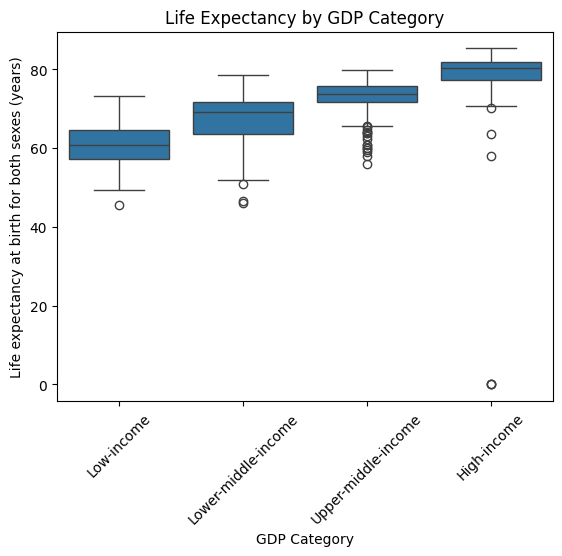

In [41]:
sns.boxplot(x='GDP Category', y='Life expectancy at birth for both sexes (years)', data=merged_df)
plt.title("Life Expectancy by GDP Category")
plt.xticks(rotation=45)  #here I rotate labels for better visibility
plt.show()

High-income countries exhibit the highest median life expectancy (around 80 years), with minimal variation, just like the previous table indicated. Low-income countries have the lowest life expectancy, with a median around 60 years, and more variability. Lower-middle and upper-middle-income countries show intermediate life expectancy, reflecting progress in health indicators as economies grow.

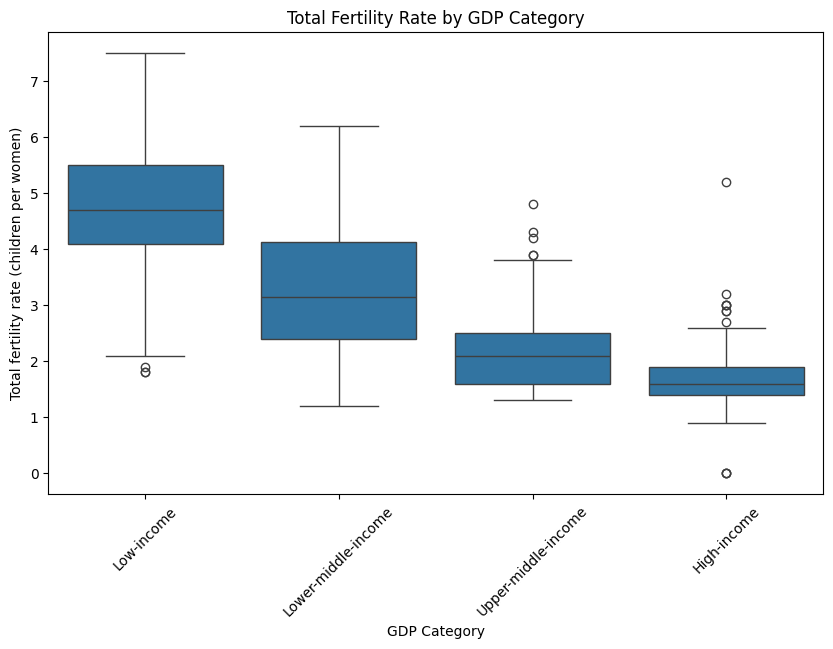

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='GDP Category', y='Total fertility rate (children per women)', data=merged_df)
plt.title('Total Fertility Rate by GDP Category')
plt.xticks(rotation=45) #here I rotate labels for better visibility
plt.show()

Low-income countries have the highest fertility rates, with a median above 4 children per woman. On the other hand, high-income countries exhibit the lowest fertility rates, with a median below 2 children per woman. Middle-income categories show transitional fertility rates.

The last analysis will create time series trends to examine how fertility and life expectancy have evolved over time for each income group.

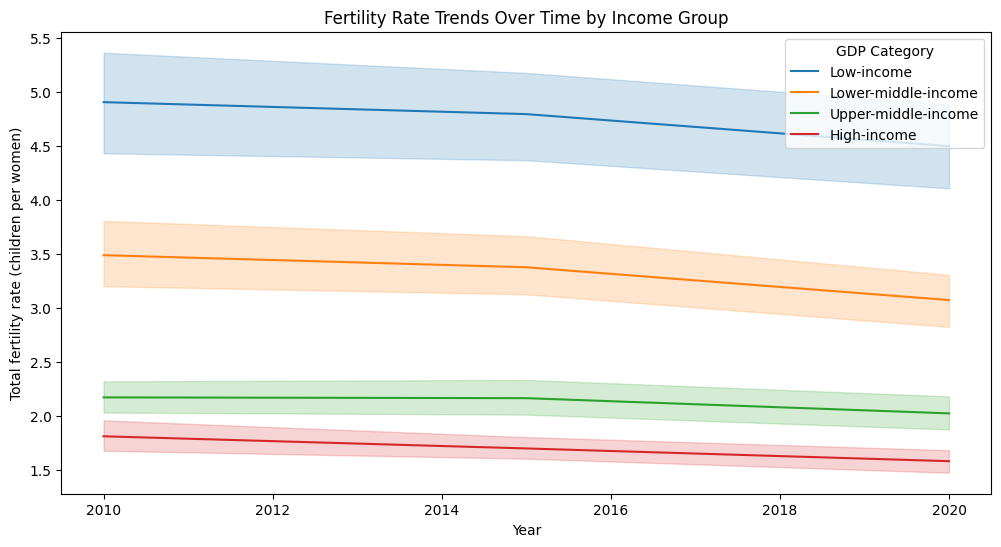

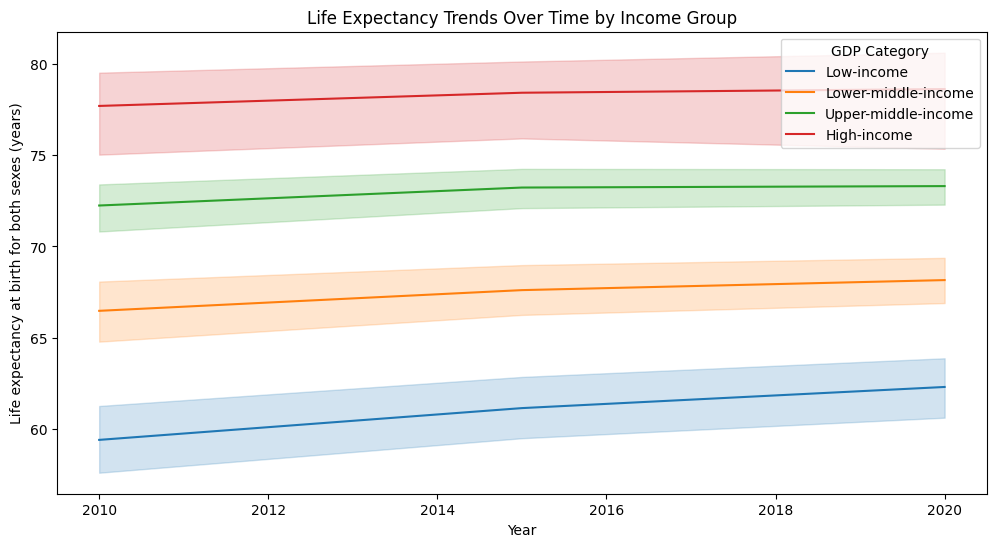

In [43]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='Total fertility rate (children per women)', hue='GDP Category')
plt.title('Fertility Rate Trends Over Time by Income Group')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='Life expectancy at birth for both sexes (years)', hue='GDP Category')
plt.title('Life Expectancy Trends Over Time by Income Group')
plt.show()

While, in general, fertility rates tend to decline and life expectancy tends to increase, there are clear differences between income groups. To determine whether these differences are also significant, I can perform an ANOVA test for fertility rates and an ANOVA test for life expectancy.

In [44]:
anova_fertility = f_oneway(
    merged_df[merged_df['GDP Category'] == 'Low-income']['Total fertility rate (children per women)'],
    merged_df[merged_df['GDP Category'] == 'Lower-middle-income']['Total fertility rate (children per women)'],
    merged_df[merged_df['GDP Category'] == 'Upper-middle-income']['Total fertility rate (children per women)'],
    merged_df[merged_df['GDP Category'] == 'High-income']['Total fertility rate (children per women)']
)

anova_life_expectancy = f_oneway(
    merged_df[merged_df['GDP Category'] == 'Low-income']['Life expectancy at birth for both sexes (years)'],
    merged_df[merged_df['GDP Category'] == 'Lower-middle-income']['Life expectancy at birth for both sexes (years)'],
    merged_df[merged_df['GDP Category'] == 'Upper-middle-income']['Life expectancy at birth for both sexes (years)'],
    merged_df[merged_df['GDP Category'] == 'High-income']['Life expectancy at birth for both sexes (years)']
)

print("ANOVA result for fertility rates:", anova_fertility)
print("ANOVA result for life expectancy:", anova_life_expectancy)


ANOVA result for fertility rates: F_onewayResult(statistic=317.55782864577566, pvalue=1.512032375540397e-129)
ANOVA result for life expectancy: F_onewayResult(statistic=159.39700142664464, pvalue=1.6373739285249366e-78)


For fertility rates, the F-statistic is 317.56, indicating a large variance in fertility rates between income groups. More importantly, the p-value is extremely small (1.51 × 10⁻¹²⁹), far below any standard significance threshold (e.g., 0.05). This confirms that the differences in fertility rates between income groups are statistically significant.

For life Expectancy, the F-statistic is 159.40, also indicating a substantial variance in life expectancy between income groups. The p-value is similarly very small (1.64 × 10⁻⁷⁸), confirming the statistical significance of differences in life expectancy among income groups.

These results suggests a strong association between income levels and these demographic indicators.

# **Conclusion**

The current analysis highlights the significant relationships between economic development, as measured by GDP per capita and GDP growth rates, and two key demographic indicators: fertility rates and life expectancy. Fertility rates decline as GDP per capita increases, with high-income countries exhibiting the lowest median fertility rate (1.6 children per woman) compared to the much higher rates observed in low-income countries (4.7 children per woman). Regression analysis confirmed this negative relationship, showing that even small increases in GDP per capita are associated with significant reductions in fertility. These findings could be explained by the demographic transition model, which links higher levels of economic development to improved education, urbanization, and access to family planning services, leading to lower fertility. However, the multivariate regression analysis presented a surprising result: GDP growth rates were positively and significantly associated with fertility rates. This stands in contrast to the negative relationship between GDP per capita and fertility. This could reflect the fact that GDP growth, particularly in low- and middle-income countries, might initially drive higher fertility due to improved child survival rates and economic optimism, while structural changes like widespread access to family planning lag behind. This finding suggests that short-term growth may not immediately lead to lower fertility.

Similarly, life expectancy shows a positive association with GDP per capita, rising significantly from a median of around 61 years in low-income countries to approximately 80 years in high-income nations. The regression results indicate that while GDP per capita strongly predicts life expectancy, GDP growth rates exhibit a small negative association. This suggests that rapid economic growth, particularly in lower-income settings, may not immediately translate into better health outcomes, as structural changes in healthcare and living standards often lag behind. Finally, statistical tests (ANOVA) confirmed significant differences in both fertility rates and life expectancy across income groups.

These results reflect a narrative of demographic transition. Economic development fosters longer life expectancy through improved healthcare, nutrition, and living conditions, while simultaneously lowering fertility rates. However, the analysis also highlights persistent disparities between income groups. Middle-income countries show transitional trends, while low-income nations struggle with limited access to essential services. This sustains the trend in poorer countries of high fertility, since larger families often serve as a source of economic support, and lower life expectancy due to limited healthcare.

Despite these insights, the current analysis has some limitations. The distribution of GDP per capita is highly skewed, with a small number of very wealthy countries influencing the results. Outliers in fertility and life expectancy also complicate the interpretation of trends. Additionally, the regression models suggest potential multicollinearity, which may affect the precision of coefficients. In the regression examining life expectancy, the Omnibus and Jarque-Bera tests also indicated significant deviations from normality in the residuals. This suggests that the ordinary least squares (OLS) model may not be the most suitable for this analysis. Alternative approaches, such as robust regression, quantile regression, or generalized additive models (GAMs), could better account for non-normality and non-linear relationships. Lastly, while the relationships observed are strong, the analysis cannot establish causality; for instance, lower fertility could also contribute to economic growth, rather than solely being a result of it.

In conclusion, the analysis demonstrates that economic development is closely tied to lower fertility rates and longer life expectancy. However, significant disparities persist across income groups, requiring targeted interventions to address underlying inequities. While economic growth remains an important driver of improved health and demographic outcomes, future research should incorporate additional variables (e.g., education levels) to provide a more nuanced understanding of the complex interplay between economic and demographic factors.